# Train an existing detectron model on a custom dataset with detectron2

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

***新学到***：Python assert（断言）用于判断一个表达式，在表达式条件为 false 的时候触发异常。语法为

In [2]:
assert False,"assert error happens"
print("If assert false, cannot print")

AssertionError: assert error happens

In [3]:
assert True
print("If assert false, cannot print")

If assert false, cannot print


We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category.

In [4]:
# Already downloaded
# # download, decompress the data
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
# !unzip balloon_dataset.zip > /dev/null

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).

In [5]:
import os
import json

img_dir =  './balloon/train'
json_file = os.path.join(img_dir,'via_region_data.json')
json_file

'./balloon/train/via_region_data.json'

In [6]:
with open(json_file) as f:
    imgs_anns = json.load(f)
imgs_anns.items()

dict_items([('34020010494_e5cb88e1c4_k.jpg1115004', {'fileref': '', 'size': 1115004, 'filename': '34020010494_e5cb88e1c4_k.jpg', 'base64_img_data': '', 'file_attributes': {}, 'regions': {'0': {'shape_attributes': {'name': 'polygon', 'all_points_x': [1020, 1000, 994, 1003, 1023, 1050, 1089, 1134, 1190, 1265, 1321, 1361, 1403, 1428, 1442, 1445, 1441, 1427, 1400, 1361, 1316, 1269, 1228, 1198, 1207, 1210, 1190, 1177, 1172, 1174, 1170, 1153, 1127, 1104, 1061, 1032, 1020], 'all_points_y': [963, 899, 841, 787, 738, 700, 663, 638, 621, 619, 643, 672, 720, 765, 800, 860, 896, 942, 990, 1035, 1079, 1112, 1129, 1134, 1144, 1153, 1166, 1166, 1150, 1136, 1129, 1122, 1112, 1084, 1037, 989, 963]}, 'region_attributes': {}}}}), ('25899693952_7c8b8b9edc_k.jpg814535', {'fileref': '', 'size': 814535, 'filename': '25899693952_7c8b8b9edc_k.jpg', 'base64_img_data': '', 'file_attributes': {}, 'regions': {'0': {'shape_attributes': {'name': 'polygon', 'all_points_x': [586, 510, 441, 389, 331, 268, 196, 158, 135

In [7]:
dataset_dicts=[]
dataset_dicts

[]

In [2]:
import cv2
import itertools
import numpy as np
from detectron2.structures import BoxMode

for _,v in imgs_anns.items():
    record={}
    filename=os.path.join(img_dir, v["filename"])
    height, width = cv2.imread(filename).shape[:2]
    record["file_name"]=filename
    record["height"]=height
    record["width"]=width
    
    annos=v["regions"]
    objs=[]
    for _,anno in annos.items():
        assert not anno["region_attributes"],"Winter comes, Error happens"
        anno = anno["shape_attributes"]
        px = anno["all_points_x"]
        py = anno["all_points_y"]
        poly = [(x+0.5, y+0.5) for x,y in zip(px, py)]
        poly=list(itertools.chain.from_iterable(poly))
        obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
        objs.append(obj)
    record["annotations"] = objs
    dataset_dicts.append(record)
print(dataset_dicts)

NameError: name 'imgs_anns' is not defined

In [2]:
import os
import json
import numpy as np
import itertools
from detectron2.structures import BoxMode

# write a function that loads the dataset into detectron2's standard format
def get_balloon_dicts(img_dir):
    json_file=os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    dataset_dicts=[]
    for _,v in imgs_anns.items():
        record={}
        
        filename=os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        record["file_name"]=filename
        record["height"]=height
        record["width"]=width
        
        annos=v["regions"]
        objs=[]
        for _,anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x+0.5, y+0.5) for x,y in zip(px, py)]
            poly = list(itertools.chain.from_iterable(poly))
            
            obj={
                "bbox":[np.min(px),np.min(py),np.max(px),np.max(py)],
                "bbox_mode":BoxMode.XYXY_ABS,
                "segmentation":[poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"]=objs
        dataset_dicts.append(record)
    return dataset_dicts

        

Here, the snippet associates the balloon dataset with a function that returns the data. If you do not modify downstream code (i.e., you use the standard data loader and data mapper), then the function has to return a list of dicts in detectron2's standard dataset format, which is similar to COCO's json annotations, described [here](https://detectron2.readthedocs.io/tutorials/datasets.html)

In [3]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    DatasetCatalog.register("balloon/"+d, lambda d = d: get_balloon_dicts("balloon/"+d)) # lambda: d = d，此处为参数d设置默认值d
    MetadataCatalog.get("balloon/"+d).set(thing_classes=["balloon"])
balloon_metadata=MetadataCatalog.get("balloon/train")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [4]:
import random
from detectron2.utils.visualizer import Visualizer
import cv2
# from google.colab.patches import cv2_imshow

dataset_dicts = get_balloon_dicts('balloon/val')
for d in random.sample(dataset_dicts,3):
    img = cv2.imread(d['file_name'])
    visualizer = Visualizer(img[:,:,::-1],metadata=balloon_metadata,scale=0.3)
    vis=visualizer.draw_dataset_dict(d)
    cv2.imshow('image samples',vis.get_image()[:,:,::-1])
    cv2.waitKey(0)
    cv2.destroyAllWindows()  

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. 

In [12]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("../configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("balloon/train",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

Config '../configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


Now, we perform inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [8]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS=os.path.join(cfg.OUTPUT_DIR,"model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST=0.7
cfg.DATASETS.TEST=('balloon/val')
predictor = DefaultPredictor(cfg)

In [10]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts('balloon/val')
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d['file_name'])
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1],
                   metadata=balloon_metadata,
                   scale=0.3,
                   instance_mode=ColorMode.IMAGE_BW # remove the color of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs['instances'].to('cpu'))
    cv2.imshow("results",v.get_image()[:,:,::-1])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Training from Scratch

In [5]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("../configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")
cfg.DATASETS.TRAIN = ("balloon/train",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000   # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

Config '../configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [6]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS=os.path.join(cfg.OUTPUT_DIR,"model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST=0.7
cfg.DATASETS.TEST=('balloon/val')
predictor = DefaultPredictor(cfg)

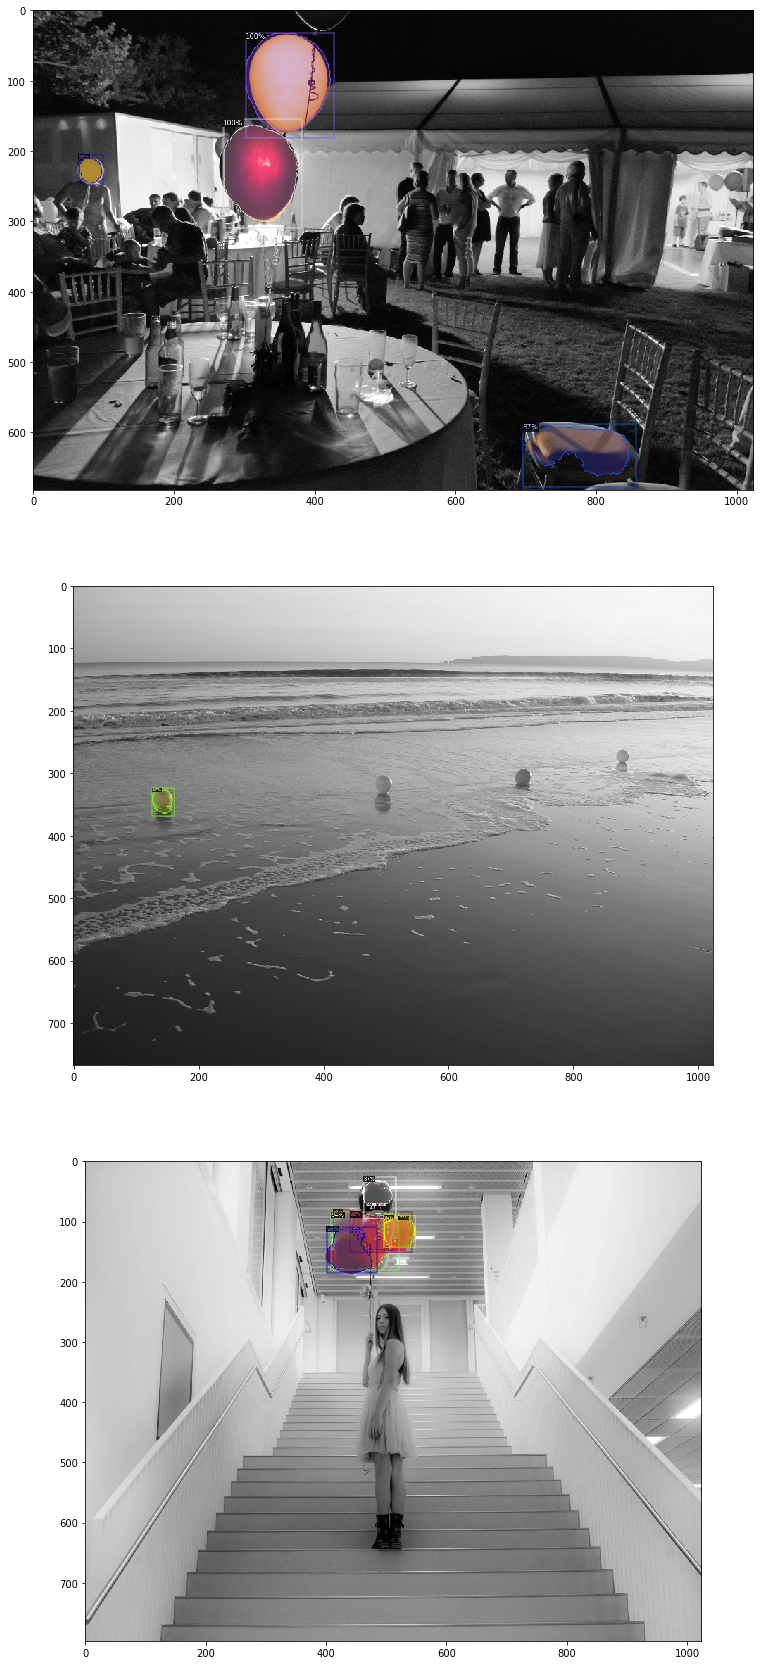

In [12]:
from detectron2.utils.visualizer import ColorMode
from matplotlib import pyplot as plt

dataset_dicts = get_balloon_dicts('balloon/val')
i=1
plt.figure(figsize=(100,30))
for d in random.sample(dataset_dicts, 3):
    im = plt.imread(d['file_name'])
#     im = cv2.imread(d['file_name'])
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1],
                   metadata=balloon_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW # remove the color of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs['instances'].to('cpu'))
    plt.subplot(3,1,i)
    i+=1
    plt.imshow(v.get_image()[:,:,::-1])
#     cv2.imshow("results",v.get_image()[:,:,::-1])
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

**Training from scratch**迭代1000次比不上预训练模型迭代300次，但也许继续增大迭代次数能够更好一点